# Iris Species Classification: EDA and Model Training


## 1. Load Libraries and Data


### 1.1 Import/Load Libraries

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os


### 1.2 Load the dataset

In [99]:
df = pd.read_csv('data/iris.csv')
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


## 2. Exploratory Data Analysis (EDA)


### 2.1 Initial Data Overview
Let's start by Examining the basic characteristics of the dataset, including its dimensions and a sample of the data.


In [100]:
# Display dataset shape
print(f"Dataset dimensions: {df.shape}")

# Display first few rows for context
print("\nFirst 5 rows:")
print(df.head())

# Display data types and non-null counts
print("\nDataset Info:")
df.info()

# Display summary statistics 
print("\nSummary Statistics:")
print(df.describe(include='all'))


Dataset dimensions: (150, 5)

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4

### 2.2 Missing Value Analysis
Checking for any missing values in the dataset is a crucial first step in data cleaning.


In [101]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

if missing_values.sum() == 0:
    print("\nNo missing values found in the dataset.")
else:
    print(f"\nTotal missing values found: {missing_values.sum()}")


Missing values per column:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

No missing values found in the dataset.


### 2.3 Target Variable Distribution
Understanding the distribution of the target variable ('species') is important for classification tasks. It helps to see if the classes are balanced.


Species distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


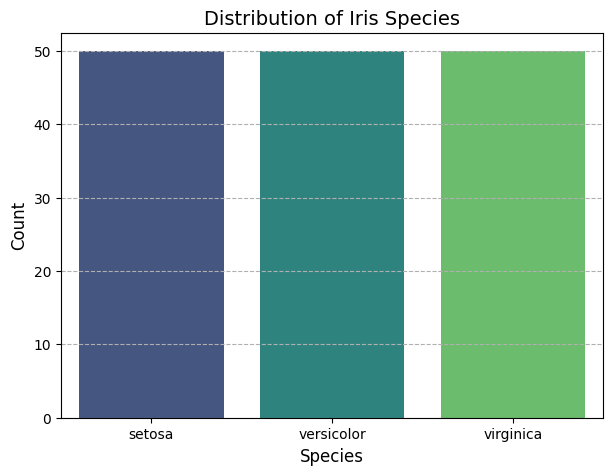

In [102]:
# Distribution of target variable
species_counts = df['species'].value_counts()
print("Species distribution:")
print(species_counts)

plt.figure(figsize=(7, 5)) 
sns.countplot(x='species', data=df, palette='viridis', order=species_counts.index , hue='species',legend=False) # Added order
plt.title('Distribution of Iris Species', fontsize=14)
plt.xlabel('Species', fontsize=12) 
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()


The dataset appears to be perfectly balanced with 50 samples for each species. 

### 2.4 Univariate Feature Analysis
Let's examine the distribution of each numerical feature individually. This helps in understanding the range, central tendency, and spread of each feature using histograms and Kernel Density Estimate (KDE) plots.


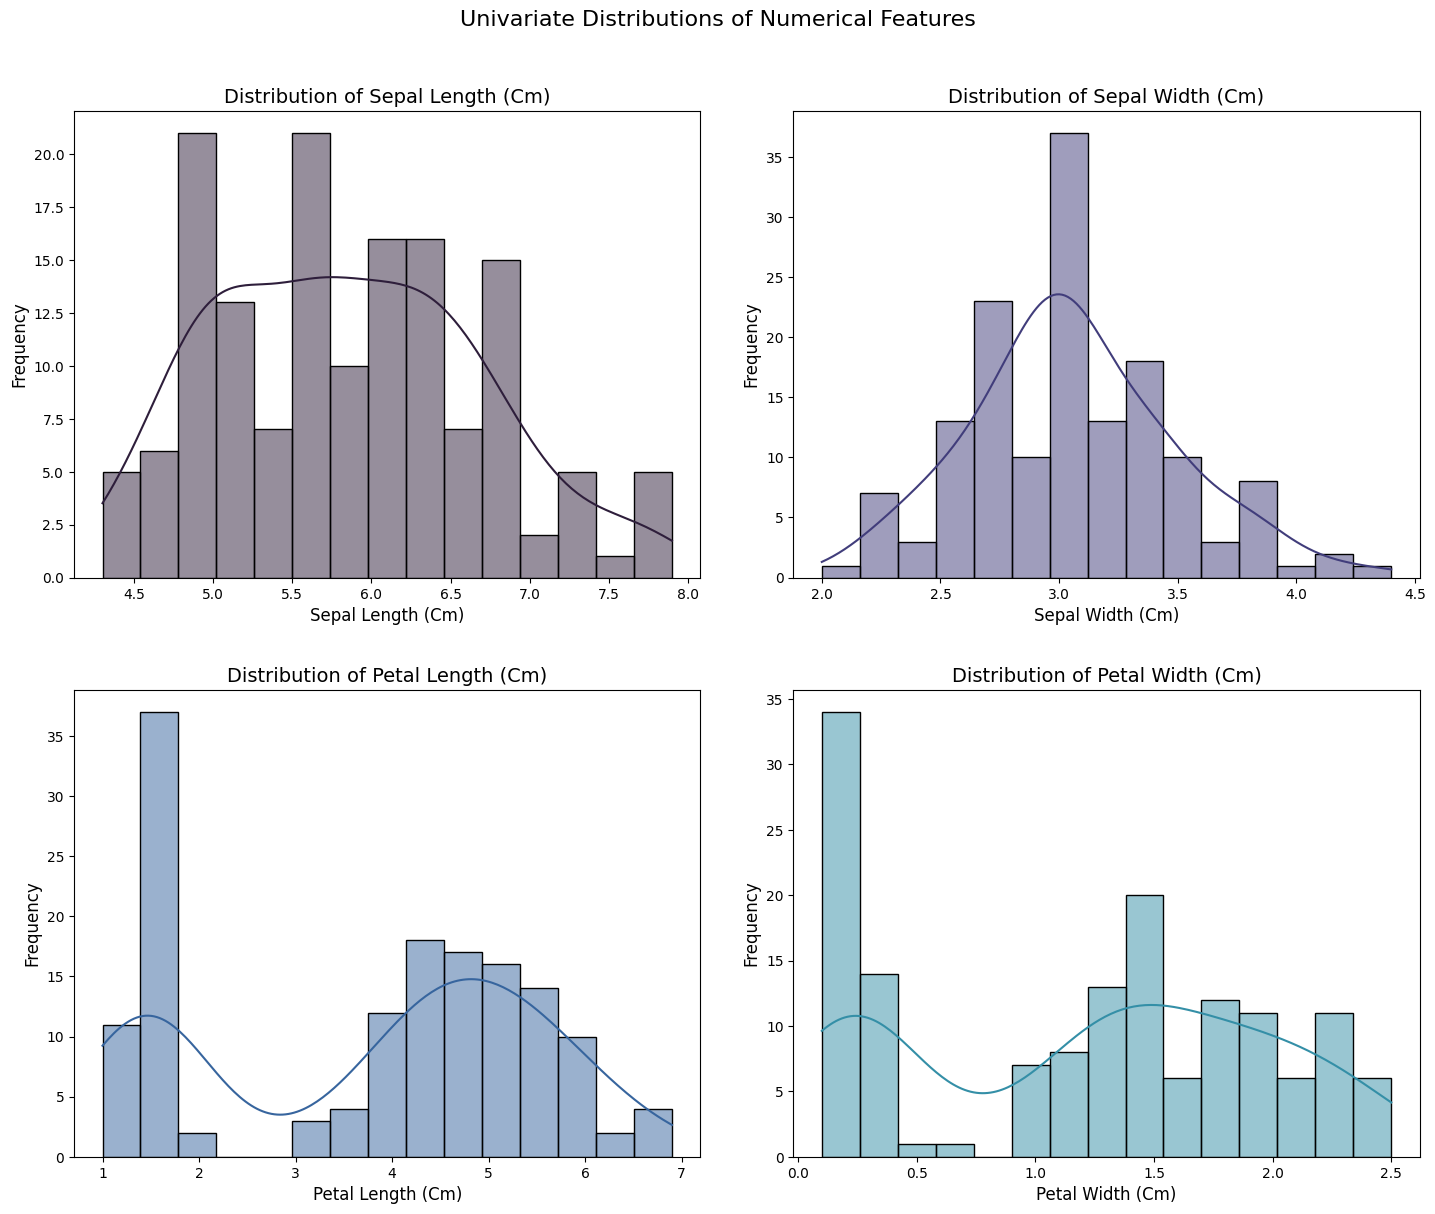

In [103]:
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12)) # Adjusted figure size
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[feature], kde=True, bins=15, color=sns.color_palette('mako')[i%len(sns.color_palette('mako'))]) # Cycle through palette
    plt.title(f'Distribution of {feature.replace("_", " ").title()}', fontsize=14)
    plt.xlabel(feature.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
plt.tight_layout(pad=3.0) # Padding
plt.suptitle('Univariate Distributions of Numerical Features', fontsize=16, y=1.03) # Overall title
plt.show()


Observations from univariate analysis:
- Sepal Length (cm) and Sepal Width (cm) show distributions that are somewhat unimodal and symmetric, resembling a normal distribution.
- Petal Length (cm) and Petal Width (cm) distributions appear to be bimodal or multimodal, suggesting distinct groups within the data, likely corresponding to different species.

### 2.5 Bivariate Analysis: Pairplots
Pairplots are excellent for visualizing relationships between all pairs of features, colored by the target variable. This can reveal how features interact and how well they separate the classes.


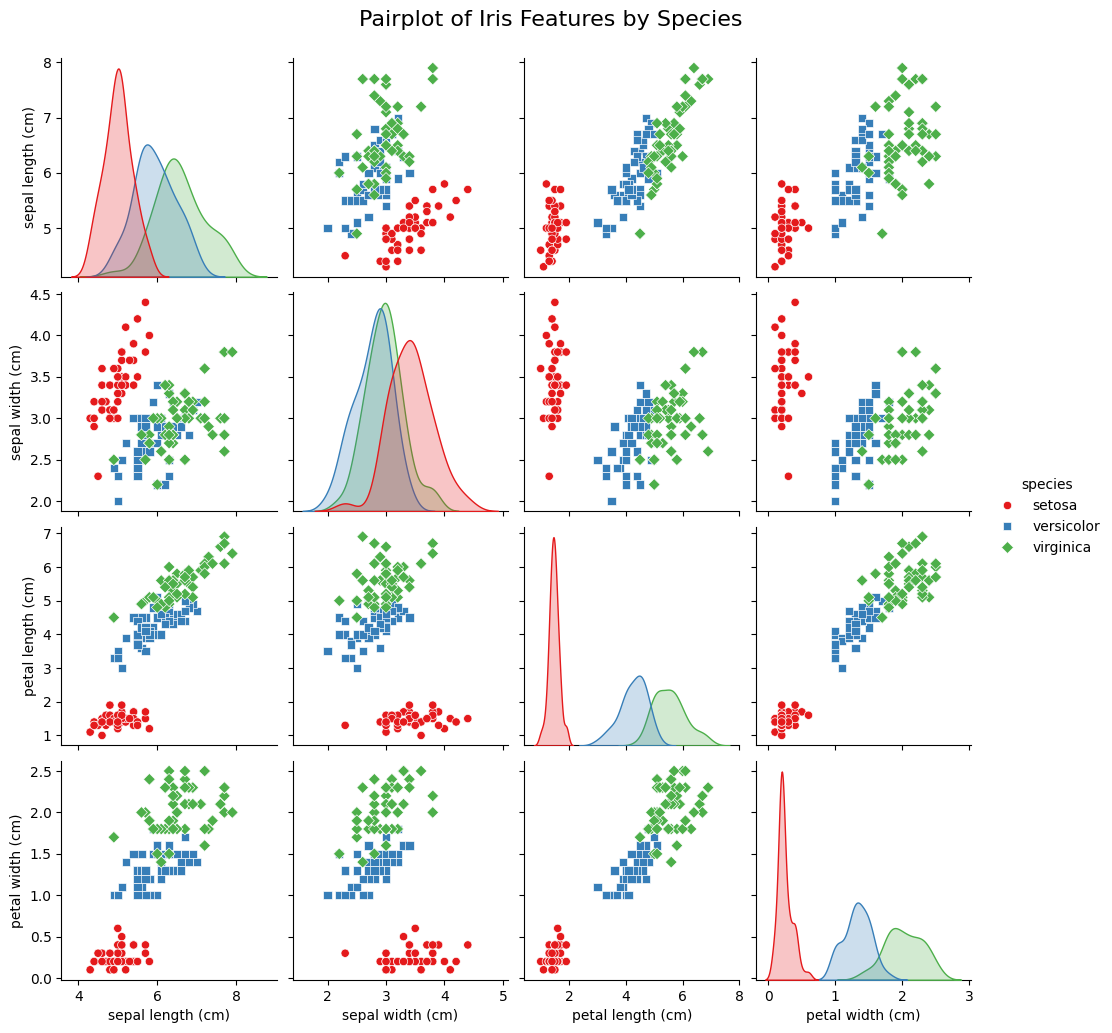

In [104]:
# Pairplot to visualize relationships between features
g = sns.pairplot(df, hue='species', markers=['o', 's', 'D'], palette='Set1', diag_kind='kde')
g.fig.suptitle('Pairplot of Iris Features by Species', y=1.03, fontsize=16)
plt.show()

Key observations from the pairplot:
- Iris-setosa (one color) is clearly linearly separable from the other two species, especially using petal length and petal width.
- Iris-versicolor and Iris-virginica show some overlap, particularly with sepal length and sepal width. However, they are more distinguishable when considering petal dimensions.
- The diagonal KDE plots reinforce the observations from the univariate analysis regarding feature distributions for each species.

### 2.6 Bivariate Analysis: Boxplots by Species
Boxplots show the distribution of each numerical feature grouped by the target variable ('species'). They are useful for comparing the distributions and identifying differences in medians, quartiles, and potential outliers.


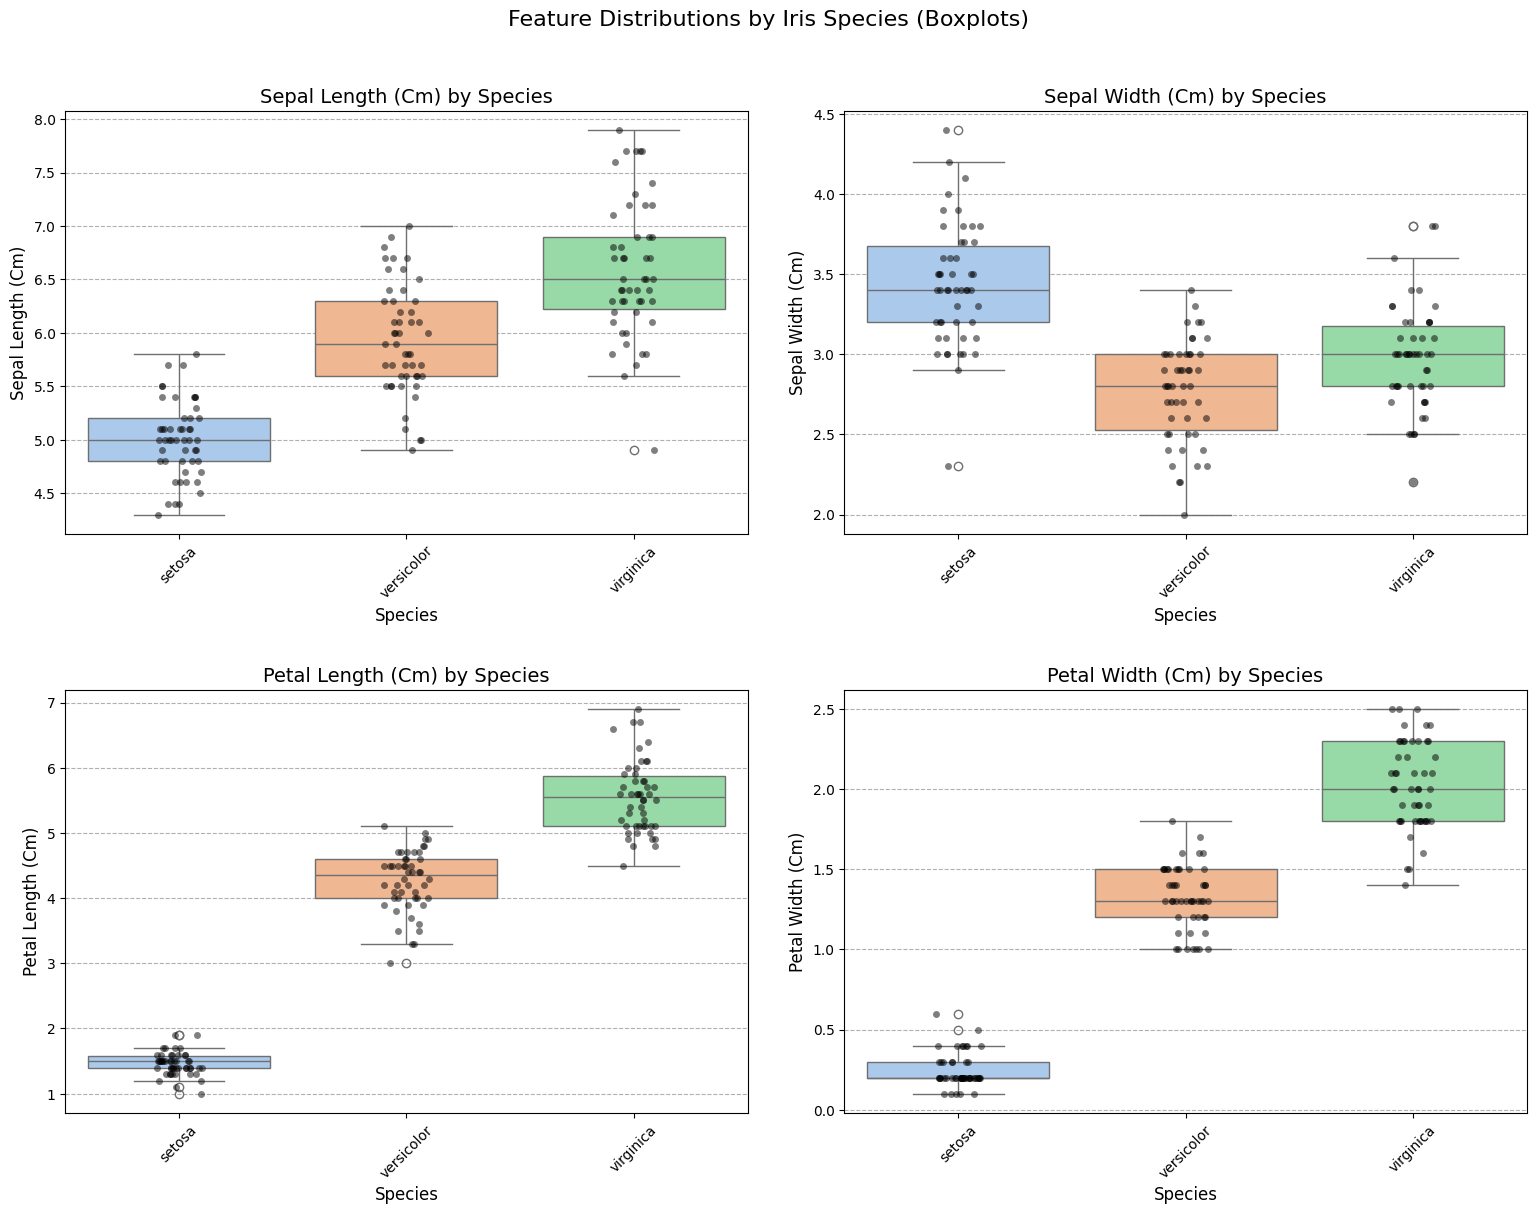

In [105]:
plt.figure(figsize=(16, 12)) # Adjusted figure size
feature_cols = df.columns[:-1] # Assuming last column is 'species'
for i, feature in enumerate(feature_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='species', y=feature, data=df, palette='pastel', hue = 'species' , legend=False ) # Alternate palettes for variety
    sns.stripplot(x='species', y=feature, data=df, color='black', alpha=0.5, jitter=True, marker='o') # Overlay stripplot
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--')
    plt.title(f'{feature.replace("_", " ").title()} by Species', fontsize=14)
    plt.xlabel('Species', fontsize=12)
    plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
plt.tight_layout(pad=3.0) # Added padding
plt.suptitle('Feature Distributions by Iris Species (Boxplots)', fontsize=16, y=1.03)
plt.show()



Insights from boxplots:
- Petal Length (cm) and Petal Width (cm) show significant differences across the three species, with Iris-setosa having the smallest values and Iris-virginica the largest.
- Iris-setosa has a very narrow distribution for petal features, indicating less variability compared to the other species.
- While there's overlap in Sepal Length (cm) and Sepal Width (cm) between Iris-versicolor and Iris-virginica, their medians and interquartile ranges differ.
- Iris-versicolor appears to have the smallest Sepal Width (cm) on average among the three.

### 2.7 Correlation Analysis
A correlation heatmap helps to understand the linear relationships between numerical features.


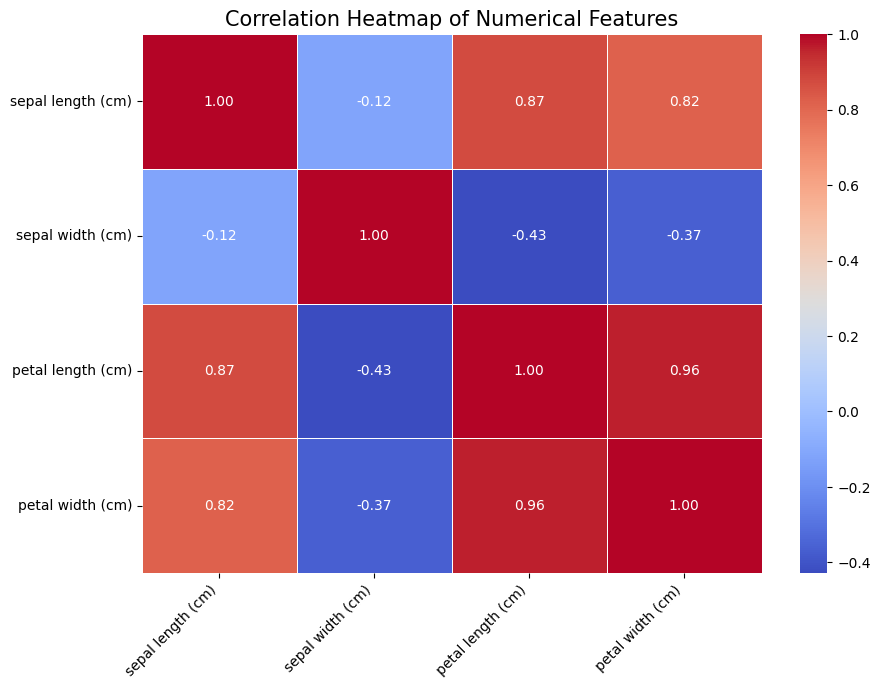

In [106]:
# Ensure only numerical columns are used for correlation
numerical_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 7)) 
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


Correlation observations:
- Strong positive correlation between Petal Length (cm) and Petal Width (cm) (0.96). This is expected as longer petals tend to be wider.
- Strong positive correlation between Sepal Length (cm) and Petal Length (cm) (0.87), and Sepal Length (cm) and Petal Width (cm) (0.82).
- Moderate negative correlation between Sepal Width (cm) and Petal Length (cm) (-0.43) and Sepal Width (cm) and Petal Width (cm) (-0.37).

## 3. Data Preprocessing


In [107]:
# Separate features (X) and target (y)
X = df.drop('species', axis=1)
y = df['species']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Original species labels: {le.classes_}")
print(f"Encoded species labels: {np.unique(y_encoded)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nX_train shape: {X_train_scaled.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Original species labels: ['setosa' 'versicolor' 'virginica']
Encoded species labels: [0 1 2]

X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120,)
y_test shape: (30,)


## 4. Model Training and Comparison


--- Model Training and Evaluation ---

--- Logistic Regression ---
Cross-Validation Accuracy (mean): 0.8917 (+/- 0.0204)
Test Set Accuracy: 0.8333
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.86      0.60      0.71        10
   virginica       0.69      0.90      0.78        10

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30

Confusion Matrix on Test Set:


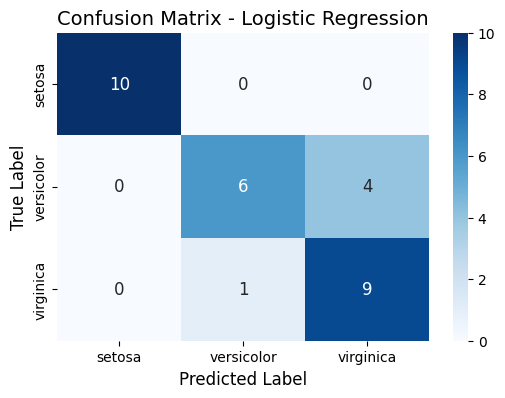


--- K-Nearest Neighbors ---
Cross-Validation Accuracy (mean): 0.9667 (+/- 0.0312)
Test Set Accuracy: 0.9333
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

Confusion Matrix on Test Set:


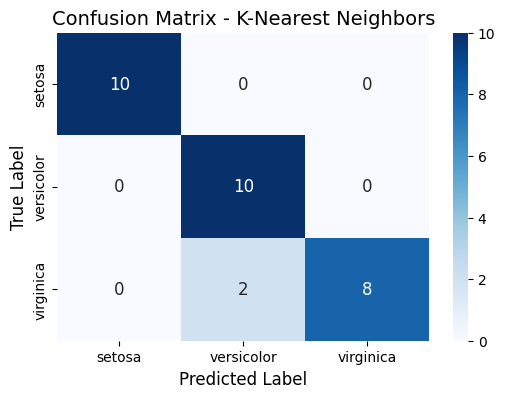


--- Support Vector Machine ---
Cross-Validation Accuracy (mean): 0.9667 (+/- 0.0312)
Test Set Accuracy: 0.9667
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix on Test Set:


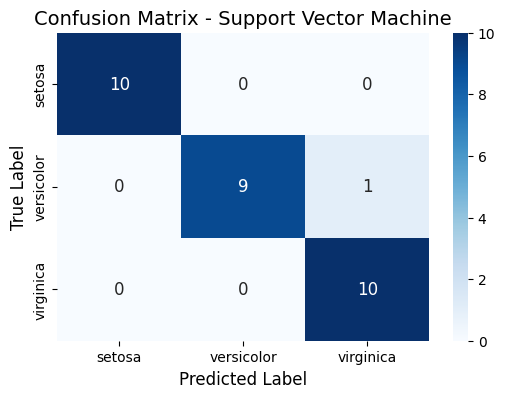


--- Decision Tree ---
Cross-Validation Accuracy (mean): 0.9417 (+/- 0.0204)
Test Set Accuracy: 0.9333
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

Confusion Matrix on Test Set:


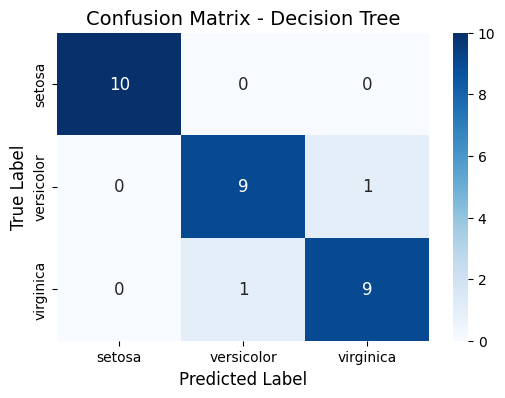


--- Random Forest ---
Cross-Validation Accuracy (mean): 0.9500 (+/- 0.0167)
Test Set Accuracy: 0.9000
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30

Confusion Matrix on Test Set:


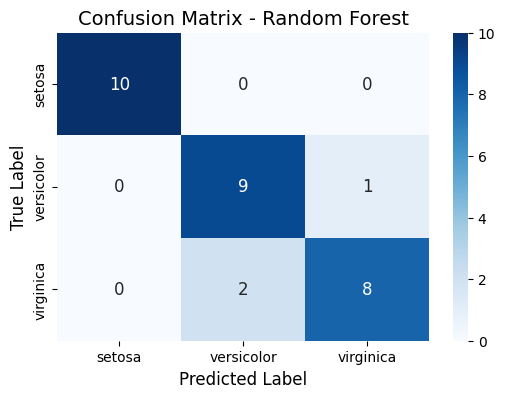


--- Gradient Boosting ---
Cross-Validation Accuracy (mean): 0.9583 (+/- 0.0264)
Test Set Accuracy: 0.9667
Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion Matrix on Test Set:


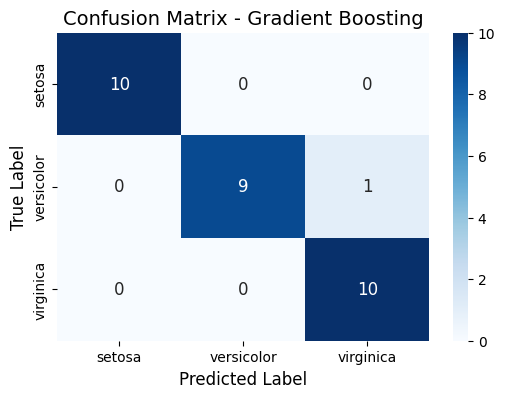

In [108]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(), # n_neighbors=5 default
    "Support Vector Machine": SVC(probability=True, random_state=42), # probability=True for confidence scores later
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
trained_models = {} # To store trained model instances

print("--- Model Training and Evaluation ---")
for name, model in models.items():
    # Fit model on scaled training data
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model # Store trained model

    # Make predictions on scaled test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Cross-validation scores on scaled training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')

    results[name] = {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm
    }

    print(f"\n--- {name} ---")
    print(f"Cross-Validation Accuracy (mean): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"Test Set Accuracy: {accuracy:.4f}")
    print("Classification Report on Test Set:")
    print(report)
    print("Confusion Matrix on Test Set:")
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_,
                annot_kws={"size": 12})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {name}', fontsize=14)
    plt.show()


## 5. Hyperparameter Tuning (For Random Forest)
Let's perform hyperparameter tuning for Random Forest, which often performs well on such tasks.



--- Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best Random Forest Parameters found: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Accuracy (Random Forest) from GridSearchCV: 0.9583

Tuned Random Forest Test Set Accuracy: 0.9667
Tuned Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Tuned Random Forest Confusion Matrix on Test Set:


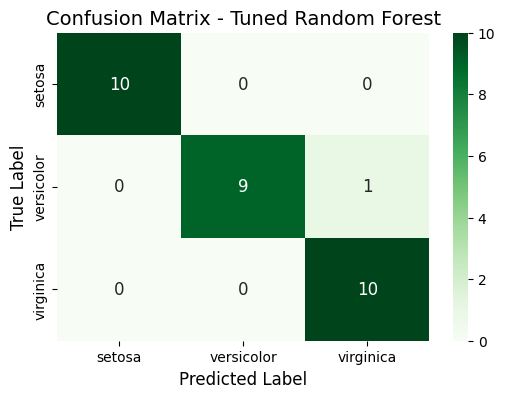

In [109]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],       # Number of trees
    'max_depth': [None, 10, 20],          # Maximum depth of trees
    'min_samples_split': [2, 5, 10],    # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples required at a leaf node
    'class_weight': [None, 'balanced']  # Added class_weight for balanced dataset
}

# Using the Random Forest instance from our models dictionary
rf_base_model = RandomForestClassifier(random_state=42) 

print("\n--- Hyperparameter Tuning for Random Forest ---")
grid_search_rf = GridSearchCV(estimator=rf_base_model, 
                              param_grid=param_grid_rf, 
                              cv=5,  # 5-fold cross-validation
                              scoring='accuracy', 
                              n_jobs=-1, # Use all available cores
                              verbose=1) # Show progress

grid_search_rf.fit(X_train_scaled, y_train)

best_rf_model = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print(f"\nBest Random Forest Parameters found: {best_params_rf}")
print(f"Best Cross-Validation Accuracy (Random Forest) from GridSearchCV: {best_score_rf:.4f}")

# Evaluate the tuned model on the test set
y_pred_best_rf = best_rf_model.predict(X_test_scaled)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
report_best_rf = classification_report(y_test, y_pred_best_rf, target_names=le.classes_, zero_division=0)
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)

print(f"\nTuned Random Forest Test Set Accuracy: {accuracy_best_rf:.4f}")
print("Tuned Random Forest Classification Report on Test Set:")
print(report_best_rf)
print("Tuned Random Forest Confusion Matrix on Test Set:")

plt.figure(figsize=(6,4))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Tuned Random Forest', fontsize=14)
plt.show()

# Update results with the tuned model
results['Tuned Random Forest'] = {
    'cv_accuracy_mean': best_score_rf, # This is the mean CV score from GridSearchCV
    'cv_accuracy_std': None, # GridSearchCV does not easily provide std of the best score directly
    'test_accuracy': accuracy_best_rf,
    'classification_report': report_best_rf,
    'confusion_matrix': cm_best_rf
}
trained_models['Tuned Random Forest'] = best_rf_model # Store the best tuned model


## 6. Select and Save the Best Model
Based on performance (considering both CV accuracy and test accuracy), we select the best model. For this project, we'll proceed with the tuned Random Forest model.


In [110]:
# For this example, we'll explicitly choose the tuned Random Forest.
# In a more complex scenario, you might programmatically select the best model from 'results'.
final_model_name = "Tuned Random Forest"
final_model = trained_models.get(final_model_name)

if final_model:
    # Create a directory for models if it doesn't exist
    MODELS_DIR = 'models'
    if not os.path.exists(MODELS_DIR):
        os.makedirs(MODELS_DIR)
        print(f"Created directory: {MODELS_DIR}")

    # Define file paths
    model_path = os.path.join(MODELS_DIR, 'iris_classifier_model.pkl')
    scaler_path = os.path.join(MODELS_DIR, 'iris_scaler.pkl')
    label_encoder_path = os.path.join(MODELS_DIR, 'iris_label_encoder.pkl')

    # Save the trained model, scaler, and label encoder
    joblib.dump(final_model, model_path)
    joblib.dump(scaler, scaler_path) # Save the scaler used for training
    joblib.dump(le, label_encoder_path) # Save the label encoder

    print(f"\nSaved {final_model_name} model to: {model_path}")
    print(f"Saved StandardScaler to: {scaler_path}")
    print(f"Saved LabelEncoder to: {label_encoder_path}")
else:
    print(f"Error: Model '{final_model_name}' not found in trained_models. Cannot save.")



Saved Tuned Random Forest model to: models\iris_classifier_model.pkl
Saved StandardScaler to: models\iris_scaler.pkl
Saved LabelEncoder to: models\iris_label_encoder.pkl


## 7. Summary of Model Performance
Let's summarize the performance of all evaluated models.



--- Model Performance Summary ---
                    Model  CV Accuracy Mean  CV Accuracy Std  Test Accuracy
0  Support Vector Machine          0.966667         0.031180       0.966667
1       Gradient Boosting          0.958333         0.026352       0.966667
2     Tuned Random Forest          0.958333              NaN       0.966667
3     K-Nearest Neighbors          0.966667         0.031180       0.933333
4           Decision Tree          0.941667         0.020412       0.933333
5           Random Forest          0.950000         0.016667       0.900000
6     Logistic Regression          0.891667         0.020412       0.833333


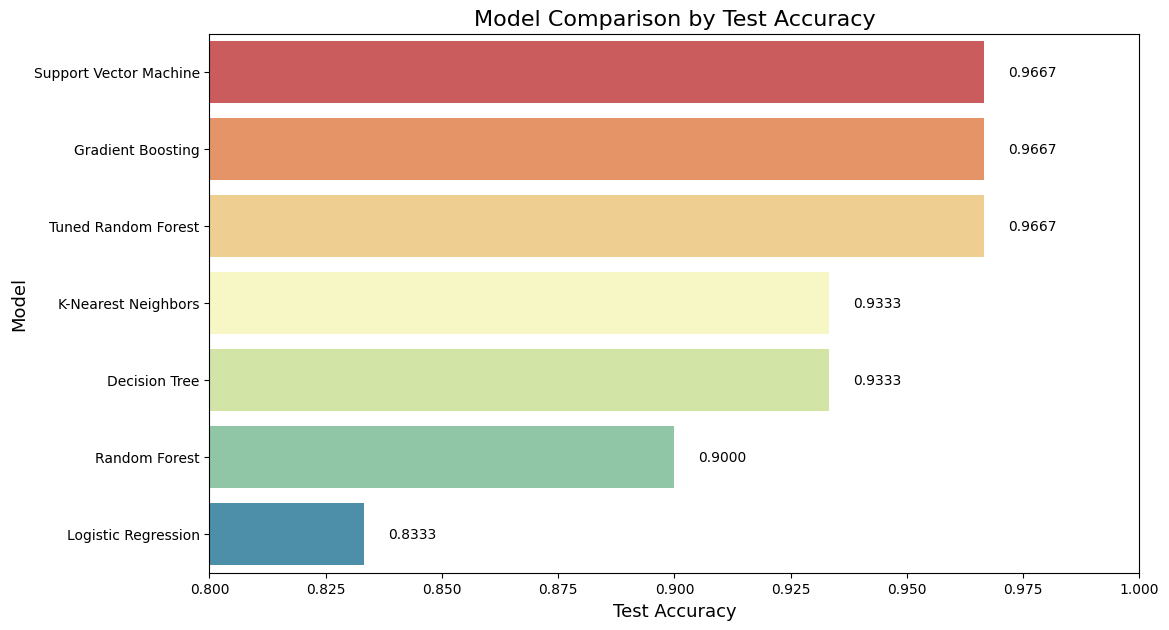

In [111]:
model_summary_list = []
for name, data in results.items():
    model_summary_list.append({
        'Model': name,
        'CV Accuracy Mean': data['cv_accuracy_mean'],
        'CV Accuracy Std': data.get('cv_accuracy_std', 'N/A'), # Use .get for std as tuned model might not have it
        'Test Accuracy': data['test_accuracy']
    })

summary_df = pd.DataFrame(model_summary_list)
summary_df = summary_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

print("\n--- Model Performance Summary ---")
print(summary_df)

# Plotting the summary
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x='Test Accuracy', y='Model', data=summary_df, palette='Spectral', dodge=False , hue = 'Model' , legend=False ) 
plt.title('Model Comparison by Test Accuracy', fontsize=16)
plt.xlabel('Test Accuracy', fontsize=13)
plt.ylabel('Model', fontsize=13)
plt.xlim(0.8, 1.0) # Adjust x-axis limits if necessary

for i in barplot.patches:
    plt.text(i.get_width() + .005, i.get_y() + .5 * i.get_height(), \
             f'{i.get_width():.4f}', \
             ha='left', va='center', fontsize=10, color='black')
plt.show()
